In [44]:
import json
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import pandas as pd
import json

def process_book_data(data):
    try:
        text_reviews_count = int(data.get('text_reviews_count', 0))
        average_rating = float(data.get('average_rating', 0))
        publication_year = int(data.get('publication_year', 0))
        num_pages = int(data.get('num_pages', 0))
        ratings_count = int(data.get('ratings_count', 0))
        book_id = int(data.get('book_id', 0))
        return {
            'text_reviews_count': text_reviews_count,
            'average_rating': average_rating,
            'similar_books': data.get('similar_books', []),
            'authors': data.get('authors', []),
            'publisher': data.get('publisher', ''),
            'num_pages': num_pages,
            'publication_year': publication_year,
            'book_id': book_id,
            'ratings_count': ratings_count,
            'title': data.get('title', '')
        }
    except ValueError:
        return None

def read_books_data(filename, max_number_of_books):
    rows_list = []
    count = 0
    with open(filename, "r") as jsonfile:
        for line in jsonfile:
            if count >= max_number_of_books:
                break
            
            try:
                data = json.loads(line)
            except json.JSONDecodeError:
                continue
            
            processed_data = process_book_data(data)
            if processed_data:
                rows_list.append(processed_data)
                count += 1
    
    return rows_list

max_number_of_books = 100000
books_data = read_books_data('goodreads_books.json', max_number_of_books)
books = pd.DataFrame(books_data)
print(books.head())


   text_reviews_count  average_rating  \
0                   1            4.00   
1                   7            4.03   
2                3282            3.49   
3                   7            4.13   
4                   6            4.22   

                                       similar_books  \
0                                                 []   
1  [19997, 828466, 1569323, 425389, 1176674, 2627...   
2  [6604176, 6054190, 2285777, 82641, 7569453, 70...   
3                                                 []   
4  [948696, 439885, 274955, 12978730, 372986, 216...   

                                  authors               publisher  num_pages  \
0   [{'author_id': '604031', 'role': ''}]      St. Martin's Press        256   
1    [{'author_id': '10333', 'role': ''}]  Nelson Doubleday, Inc.        600   
2     [{'author_id': '9212', 'role': ''}]             Atria Books        368   
3  [{'author_id': '3041852', 'role': ''}]    Yesterday's Classics        162   
4    [{'author_i

In [8]:
drop_list = ['text_reviews_count', 'average_rating', 'authors',
       'publisher', 'num_pages', 'publication_year',
       'ratings_count', 'title']
interaction_dataset = books.drop(columns=drop_list)
interaction_dataset

,similar_books,book_id
0,[],5333265
1,"[19997, 828466, 1569323, 425389, 1176674, 2627...",7327624
2,"[6604176, 6054190, 2285777, 82641, 7569453, 70...",6066819
3,[],287141
4,"[948696, 439885, 274955, 12978730, 372986, 216...",6066812
...,...,...
99995,[],3440164
99996,[],6310962
99997,"[125321, 90192, 937643, 42068, 78960, 866301, ...",8112400
99998,[],7055610


# Create the graph

In [99]:
edge_list = []
single_nodes = 0
for i in tqdm(range(len(interaction_dataset))):
    source = interaction_dataset['book_id'][i]
    if len(interaction_dataset['similar_books'][i]) == 0:
        single_nodes += 1
    for destination in interaction_dataset['similar_books'][i]:
        edge_list.append((source, int(destination)))

G = nx.Graph()
G.add_edges_from(edge_list)

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 48992.91it/s]


In [100]:
print(f"There are {single_nodes} single nodes")

There are 49199 single nodes


# Degree Distribution

In [102]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def calculate_degree_distribution(graph):
    """
    Calculate the degree distribution of the given graph.

    Parameters:
    graph (networkx.Graph): A NetworkX graph object

    Returns:
    dict: Degree distribution where key is degree and value is the number of nodes with that degree
    """
    degrees = map(graph.degree, graph.nodes())
    degree_count = np.bincount(degrees)
    degree_distribution = dict(filter(lambda x: x[1] > 0, enumerate(degree_count)))
    return degree_distribution

def plot_degree_distribution(degree_distribution):
    degrees, counts = zip(*degree_distribution.items())

    plt.bar(degrees, counts, color='blue')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.title('Degree Distribution')
    plt.show()

G = nx.fast_gnp_random_graph(100, 0.1)  # Example graph generation
distribution = calculate_degree_distribution(G)
plot_degree_distribution(distribution)


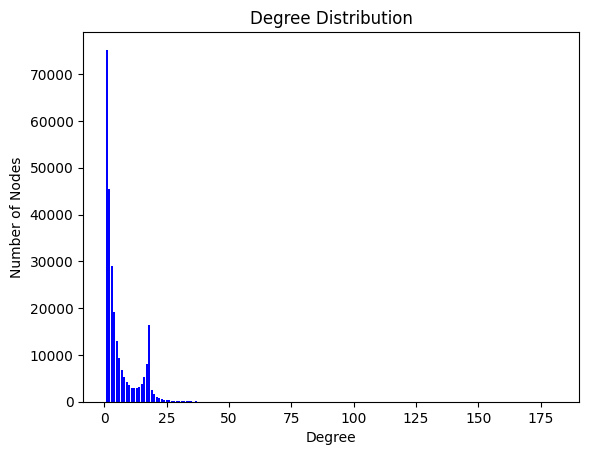

In [103]:
distribution = calculate_degree_distribution(G)
plot_degree_distribution(distribution)


# Total Nodes

In [105]:
unique_nodes = G.number_of_nodes() #interaction_dataset['book_id'].nunique()
print(f"The total number of unique nodes is: {unique_nodes}")

The total number of unique nodes is: 265356


# Total Edges

In [106]:
total_edges = G.number_of_edges()
print(f"Total number of edges in the graph: {total_edges}")

Total number of edges in the graph: 775119


# Average Path Length

In [107]:
def calculate_average_path_length(graph):
    """
    Calculate the average path length of the given graph.

    Parameters:
    graph (networkx.Graph): A NetworkX graph object

    Returns:
    float: The average path length of the graph
    """
    if nx.is_connected(graph):
        return nx.average_shortest_path_length(graph)
    else:
        raise ValueError("Graph is not connected. Average path length is undefined.")


In [108]:
try:
    avg_path_length = calculate_average_path_length(G)
    print(f"Average Path Length: {avg_path_length}")
except ValueError as e:
    print(e)

Graph is not connected. Average path length is undefined.


# Lets try using sub components of the graph and calculate the average path length on them

In [111]:
def average_path_length_of_components(graph):
    lengths = []
    for component in nx.connected_components(graph):
        print(len(lengths))
        subgraph = graph.subgraph(component)
        lengths.append(nx.average_shortest_path_length(subgraph))
    return lengths

In [ ]:
component_lengths = average_path_length_of_components(G)

0


In [ ]:
print("Average Path Length of Each Connected Component:")
for i, length in enumerate(component_lengths, 1):
    print(f"Component {i}: {length}")

# Average Clustering Coeficient

In [87]:
def calculate_average_clustering_coefficient(graph):
    """
    Calculate the average clustering coefficient of the given graph.

    Parameters:
    graph (networkx.Graph): A NetworkX graph object

    Returns:
    float: The average clustering coefficient of the graph
    """
    return nx.average_clustering(graph)

In [88]:
avg_clustering_coefficient = calculate_average_clustering_coefficient(G)
print(f"Average Clustering Coefficient: {avg_clustering_coefficient}")

Average Clustering Coefficient: 0.03526681922483934


# Diameter

In [89]:
def calculate_diameter(graph):
    """
    Calculate the diameter of the given graph.

    Parameters:
    graph (networkx.Graph): A NetworkX graph object

    Returns:
    int: The diameter of the graph or the largest connected component
    """
    if nx.is_connected(graph):
        return nx.diameter(graph)
    else:
        # Find the largest connected component
        largest_cc = max(nx.connected_components(graph), key=len)
        subgraph = graph.subgraph(largest_cc)
        return nx.diameter(subgraph)

In [ ]:
diameter = calculate_diameter(G)
print(f"Diameter: {diameter}")

# Show the figure

In [ ]:
# Optionally, draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=20)
plt.title("Graph from Node Indices")
plt.show()